## This is the script to make the coco json file for waymo dataset with our own annotation format. There are two kinds of coco anno json, one is for detection (bbox), therefore the json file only contains the bbox info of the objects in image. Another format is the segmentation-json file, which contains the bitmap info of the object contour. This bitmap can be represented in either straightward pixel coordinates or encoded as RLE. 

### This the to create the detection (bbox) json. 

In [15]:
import os
import cv2
import json, yaml
import numpy as np
from PIL import Image
from collections import OrderedDict
from pycocotools import mask as cocomask
from pycocotools import coco as cocoapi
import matplotlib.pyplot as plt

In [16]:
datapath = '/home/autolab/Data/waymo'

In [17]:
info = {"year" : 2024,
        "version" : "1.0",
        "description" : "A coco json for Waymo Open Dataset of our own LiDAR-based annotation",
        "contributor" : "Gu Junyi (Claude)",
        "url" : "https://www.junyigu-claude.com",
        "date_created" : "13-03-2024"
            }
licenses = [{"id": 1,
             "name": "Attribution-NonCommercial",
             "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
                 }]
categories  = [{"id": 1,
                "isthing": 1,
                "name": "background",
                "supercategory": "background"
               },
              {"id": 2,
                "isthing": 1,
                "name": "vehicle",
                "supercategory": "vehicle" 
              },
              {"id": 3,
                "isthing": 1,
                "name": "human",
                "supercategory": "human"    
              },
              {"id": 4,
                "isthing": 1,
                "name": "other",
                "supercategory": "other"    
              }
             ]

In [18]:
cat2id = {cat["name"]: catId+1 for catId, cat in enumerate(categories)}

In [19]:
cat2id

{'background': 1, 'vehicle': 2, 'human': 3, 'other': 4}

In [20]:
train_img_list = np.genfromtxt('/home/autolab/Data/waymo/splits_clft/train_all.txt', dtype=str)
valid_img_list = np.genfromtxt('/home/autolab/Data/waymo/splits_clft/early_stop_valid.txt', dtype=str)

In [21]:
train_img_list

array(['labeled/night/rain/camera/segment-427564647064237172_183_000_203_000_0000000198.png',
       'labeled/day/rain/camera/segment-2308204418431899833_3575_000_3595_000_with_camera_labels_0000000103.png',
       'labeled/night/rain/camera/segment-3617043125954612277_240_000_260_000_with_camera_labels_0000000197.png',
       ...,
       'labeled/day/not_rain/camera/segment-5576800480528461086_1000_000_1020_000_with_camera_labels_0000000145.png',
       'labeled/day/not_rain/camera/segment-3441838785578020259_1300_000_1320_000_with_camera_labels_0000000156.png',
       'labeled/day/not_rain/camera/segment-15578655130939579324_620_000_640_000_with_camera_labels_0000000156.png'],
      dtype='<U110')

In [22]:
valid_img_list

array(['labeled/night/rain/camera/segment-10988649507921773627_363_000_383_000_0000000010.png',
       'labeled/day/not_rain/camera/segment-14739149465358076158_4740_000_4760_000_with_camera_labels_0000000156.png',
       'labeled/day/not_rain/camera/segment-3711598698808133144_2060_000_2080_000_with_camera_labels_0000000082.png',
       ...,
       'labeled/day/not_rain/camera/segment-12681651284932598380_3585_280_3605_280_with_camera_labels_0000000062.png',
       'labeled/day/not_rain/camera/segment-5458962501360340931_3140_000_3160_000_with_camera_labels_0000000198.png',
       'labeled/day/rain/camera/segment-15539619898625779290_760_000_780_000_with_camera_labels_0000000124.png'],
      dtype='<U110')

In [23]:
def waymo_anno_class_relabel(annotation, category):
    """
    Reassign the indices of the objects in annotation(PointCloud);
    :parameter annotation: 0->ignore, 1->vehicle, 2->pedestrian, 3->sign,
                            4->cyclist, 5->background
    :return annotation: 0->background+sign, 1->vehicle
                            2->pedestrian+cyclist, 3->ingore
    """
    annotation = np.array(annotation)
    mask_ignore = annotation == 0
    mask_sign = annotation == 3
    mask_cyclist = annotation == 4
    mask_background = annotation == 5

    annotation[mask_sign] = 0
    annotation[mask_background] = 0
    annotation[mask_cyclist] = 2
    annotation[mask_ignore] = 3

    if category == 'vehicle':
        mask_rest = annotation != 1
        annotation[mask_rest] = 0
    elif category == 'human':
        mask_rest = annotation != 2
        annotation[mask_rest] = 0
    else:
        raise Exception('catrgory must be vehicle or human!')

    return annotation

In [24]:
def det_mode_get_image_annotation_pairs(image_list):
        images = []
        annotations = []
        for imId, paths in enumerate(image_list):
            segments_info = []
            rgb_path = paths
            anno_path = paths.replace('/camera', '/annotation_relabel_rgb')
            print('Processing image of', rgb_path)
            rgb_name = rgb_path.split('/')[-1].split('.')[0]
            anno_name = anno_path.split('/')[-1].split('.')[0]
            assert (rgb_name == anno_name)
        
            rgb_img = np.array(Image.open(os.path.join(datapath + '/' + rgb_path)).convert('RGB'))
            anno_img = np.array(Image.open(os.path.join(datapath + '/' + anno_path)).convert('L'))  # Here open 3-channel anno in 1-channel
            if np.all(anno_img == 0):
                continue
                
            #rgb = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
            for c in ['vehicle', 'human']:
                category_id, bbox, area = det_mode_annotation_process(c, anno_img, rgb_img)
               # cv2.rectangle(rgb,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[2]+bbox[3]), (255,0,0), 1)
                if area != 0:
                    segments_info.append({"area": area,
                          "bbox": bbox,
                          "category_id": category_id,
                          "id": imId+1,
                         "iscrowd": 0})
            #cv2.imwrite(os.path.join('./test_img/' + rgb_name + '.png'), rgb)
            images.append({"date_captured" : "2024",
                           "file_name" : rgb_name + '.png', 
                           "id" : imId+1,
                           "license" : 1,
                           "url" : "",
                           "height" : 320,
                           "width" : 480})

            annotations.append({"file_name": anno_name + '.png',
                                "image_id": imId+1,
                                "segments_info": segments_info})
        return images, annotations

In [25]:
def det_mode_annotation_process(category, anno, rgb=None):
    anno_relabel = waymo_anno_class_relabel(anno, category)
    area = np.count_nonzero(anno_relabel)
    [x, y, w, h] = cv2.boundingRect(anno_relabel)
        
    if category == 'vehicle':
        cat_id = 2
    elif category == 'human':
        cat_id = 3
    else:
         raise Exception('catrgory must be vehicle or human!')
    return cat_id, [x, y, w, h], area

In [165]:
train_img_json_det, train_anno_json_det = det_mode_get_image_annotation_pairs(train_img_list)
train_json_data_det ={"info": info,
                 "images": train_img_json_det,
                 "licenses": licenses,
                 "annotations": train_anno_json_det,
                 "categories": categories}

with open('./waymo_train_det.json', 'w') as jsonfile:
    json.dump(train_json_data_det, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/rain/camera/segment-427564647064237172_183_000_203_000_0000000198.png
Processing image of labeled/day/rain/camera/segment-2308204418431899833_3575_000_3595_000_with_camera_labels_0000000103.png
Processing image of labeled/night/rain/camera/segment-3617043125954612277_240_000_260_000_with_camera_labels_0000000197.png
Processing image of labeled/day/not_rain/camera/segment-4414235478445376689_2020_000_2040_000_with_camera_labels_0000000187.png
Processing image of labeled/day/not_rain/camera/segment-18446264979321894359_3700_000_3720_000_with_camera_labels_0000000188.png
Processing image of labeled/day/rain/camera/segment-2895681525868621979_480_000_500_000_with_camera_labels_0000000103.png
Processing image of labeled/day/rain/camera/segment-6038200663843287458_283_000_303_000_with_camera_labels_0000000042.png
Processing image of labeled/day/not_rain/camera/segment-1457696187335927618_595_027_615_027_with_camera_labels_0000000125.png
Processing image of l

In [166]:
valid_img_json_det, valid_anno_json_det = det_mode_get_image_annotation_pairs(valid_img_list)
valid_json_data_det ={"info": info,
                 "images": valid_img_json_det,
                 "licenses": licenses,
                 "annotations": valid_anno_json_det,
                 "categories": categories}

with open('./waymo_valid_det.json', 'w') as jsonfile:
    json.dump(valid_json_data_det, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/rain/camera/segment-10988649507921773627_363_000_383_000_0000000010.png
Processing image of labeled/day/not_rain/camera/segment-14739149465358076158_4740_000_4760_000_with_camera_labels_0000000156.png
Processing image of labeled/day/not_rain/camera/segment-3711598698808133144_2060_000_2080_000_with_camera_labels_0000000082.png
Processing image of labeled/day/not_rain/camera/segment-5576800480528461086_1000_000_1020_000_with_camera_labels_0000000135.png
Processing image of labeled/day/rain/camera/segment-17203196911832559434_297_000_317_000_0000000174.png
Processing image of labeled/day/not_rain/camera/segment-1999080374382764042_7094_100_7114_100_with_camera_labels_0000000188.png
Processing image of labeled/day/not_rain/camera/segment-9653249092275997647_980_000_1000_000_with_camera_labels_0000000167.png
Processing image of labeled/day/not_rain/camera/segment-15265053588821562107_60_000_80_000_with_camera_labels_0000000146.png
Processing image of label

In [26]:
test_day_fair_img_list = np.genfromtxt('/home/autolab/Data/waymo/splits_clft/test_day_fair.txt', dtype=str)
test_day_fair_img_list

array(['labeled/day/not_rain/camera/segment-1773696223367475365_1060_000_1080_000_with_camera_labels_0000000042.png',
       'labeled/day/not_rain/camera/segment-10664823084372323928_4360_000_4380_000_with_camera_labels_0000000104.png',
       'labeled/day/not_rain/camera/segment-4114454788208078028_660_000_680_000_with_camera_labels_0000000000.png',
       ...,
       'labeled/day/not_rain/camera/segment-3441838785578020259_1300_000_1320_000_with_camera_labels_0000000073.png',
       'labeled/day/not_rain/camera/segment-12358364923781697038_2232_990_2252_990_with_camera_labels_0000000135.png',
       'labeled/day/not_rain/camera/segment-13622747960068272448_1678_930_1698_930_with_camera_labels_0000000083.png'],
      dtype='<U109')

In [27]:
test_day_rain_img_list = np.genfromtxt('/home/autolab/Data/waymo/splits_clft/test_day_rain.txt', dtype=str)
test_day_rain_img_list

array(['labeled/day/rain/camera/segment-12014485239355522847_2160_000_2180_000_0000000115.png',
       'labeled/day/rain/camera/segment-17295069199227237940_3160_000_3180_000_with_camera_labels_0000000187.png',
       'labeled/day/rain/camera/segment-598054645055642984_2095_000_2115_000_0000000010.png',
       'labeled/day/rain/camera/segment-12134738431513647889_3118_000_3138_000_with_camera_labels_0000000010.png',
       'labeled/day/rain/camera/segment-10599748131695282446_1380_000_1400_000_with_camera_labels_0000000124.png',
       'labeled/day/rain/camera/segment-89454214745557131_3160_000_3180_000_with_camera_labels_0000000083.png',
       'labeled/day/rain/camera/segment-4898453812993984151_199_000_219_000_with_camera_labels_0000000000.png',
       'labeled/day/rain/camera/segment-9334364225104959137_661_000_681_000_with_camera_labels_0000000093.png',
       'labeled/day/rain/camera/segment-7453072526037272016_347_000_367_000_0000000099.png',
       'labeled/day/rain/camera/segm

In [28]:
test_night_fair_img_list = np.genfromtxt('/home/autolab/Data/waymo/splits_clft/test_night_fair.txt', dtype=str)
test_night_fair_img_list

array(['labeled/night/not_rain/camera/segment-1464917900451858484_1960_000_1980_000_with_camera_labels_0000000021.png',
       'labeled/night/not_rain/camera/segment-11252086830380107152_1540_000_1560_000_with_camera_labels_0000000166.png',
       'labeled/night/not_rain/camera/segment-2698953791490960477_2660_000_2680_000_with_camera_labels_0000000083.png',
       'labeled/night/not_rain/camera/segment-268278198029493143_1400_000_1420_000_with_camera_labels_0000000188.png',
       'labeled/night/not_rain/camera/segment-12956664801249730713_2840_000_2860_000_with_camera_labels_0000000093.png',
       'labeled/night/not_rain/camera/segment-6771922013310347577_4249_290_4269_290_with_camera_labels_0000000156.png',
       'labeled/night/not_rain/camera/segment-13940755514149579648_821_157_841_157_with_camera_labels_0000000176.png',
       'labeled/night/not_rain/camera/segment-3417928259332148981_7018_550_7038_550_with_camera_labels_0000000124.png',
       'labeled/night/not_rain/camera/se

In [29]:
test_night_rain_img_list = np.genfromtxt('/home/autolab/Data/waymo/splits_clft/test_night_rain.txt', dtype=str)
test_night_rain_img_list

array(['labeled/night/rain/camera/segment-3617043125954612277_240_000_260_000_with_camera_labels_0000000073.png',
       'labeled/night/rain/camera/segment-898816942644052013_20_000_40_000_with_camera_labels_0000000030.png',
       'labeled/night/rain/camera/segment-9320169289978396279_1040_000_1060_000_with_camera_labels_0000000145.png',
       'labeled/night/rain/camera/segment-3385534893506316900_4252_000_4272_000_with_camera_labels_0000000000.png',
       'labeled/night/rain/camera/segment-3919438171935923501_280_000_300_000_with_camera_labels_0000000094.png',
       'labeled/night/rain/camera/segment-3555170065073130842_451_000_471_000_with_camera_labels_0000000062.png',
       'labeled/night/rain/camera/segment-12303641360375776820_4378_000_4398_000_with_camera_labels_0000000125.png',
       'labeled/night/rain/camera/segment-17364342162691622478_780_000_800_000_with_camera_labels_0000000083.png',
       'labeled/night/rain/camera/segment-10988649507921773627_363_000_383_000_0000

In [30]:
test_day_fair_img_json_det, test_day_fair_anno_json_det = det_mode_get_image_annotation_pairs(test_day_fair_img_list)
test_day_fair_json_data_det ={"info": info,
                 "images": test_day_fair_img_json_det,
                 "licenses": licenses,
                 "annotations": test_day_fair_anno_json_det,
                 "categories": categories}

with open('./waymo_test_day_fair_det.json', 'w') as jsonfile:
    json.dump(test_day_fair_json_data_det, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/day/not_rain/camera/segment-1773696223367475365_1060_000_1080_000_with_camera_labels_0000000042.png
Processing image of labeled/day/not_rain/camera/segment-10664823084372323928_4360_000_4380_000_with_camera_labels_0000000104.png
Processing image of labeled/day/not_rain/camera/segment-4114454788208078028_660_000_680_000_with_camera_labels_0000000000.png
Processing image of labeled/day/not_rain/camera/segment-4960194482476803293_4575_960_4595_960_with_camera_labels_0000000176.png
Processing image of labeled/day/not_rain/camera/segment-10498013744573185290_1240_000_1260_000_with_camera_labels_0000000146.png
Processing image of labeled/day/not_rain/camera/segment-7934693355186591404_73_000_93_000_with_camera_labels_0000000104.png
Processing image of labeled/day/not_rain/camera/segment-7101099554331311287_5320_000_5340_000_with_camera_labels_0000000114.png
Processing image of labeled/day/not_rain/camera/segment-9415086857375798767_4760_000_4780_000_with_camera_la

In [31]:
test_day_rain_img_json_det, test_day_rain_anno_json_det = det_mode_get_image_annotation_pairs(test_day_rain_img_list)
test_day_rain_json_data_det ={"info": info,
                 "images": test_day_rain_img_json_det,
                 "licenses": licenses,
                 "annotations": test_day_rain_anno_json_det,
                 "categories": categories}

with open('./waymo_test_day_rain_det.json', 'w') as jsonfile:
    json.dump(test_day_rain_json_data_det, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/day/rain/camera/segment-12014485239355522847_2160_000_2180_000_0000000115.png
Processing image of labeled/day/rain/camera/segment-17295069199227237940_3160_000_3180_000_with_camera_labels_0000000187.png
Processing image of labeled/day/rain/camera/segment-598054645055642984_2095_000_2115_000_0000000010.png
Processing image of labeled/day/rain/camera/segment-12134738431513647889_3118_000_3138_000_with_camera_labels_0000000010.png
Processing image of labeled/day/rain/camera/segment-10599748131695282446_1380_000_1400_000_with_camera_labels_0000000124.png
Processing image of labeled/day/rain/camera/segment-89454214745557131_3160_000_3180_000_with_camera_labels_0000000083.png
Processing image of labeled/day/rain/camera/segment-4898453812993984151_199_000_219_000_with_camera_labels_0000000000.png
Processing image of labeled/day/rain/camera/segment-9334364225104959137_661_000_681_000_with_camera_labels_0000000093.png
Processing image of labeled/day/rain/camera/segme

In [32]:
test_night_fair_img_json_det, test_night_fair_anno_json_det = det_mode_get_image_annotation_pairs(test_night_fair_img_list)
test_night_fair_json_data_det ={"info": info,
                 "images": test_night_fair_img_json_det,
                 "licenses": licenses,
                 "annotations": test_night_fair_anno_json_det,
                 "categories": categories}

with open('./waymo_test_night_fair_det.json', 'w') as jsonfile:
    json.dump(test_night_fair_json_data_det, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/not_rain/camera/segment-1464917900451858484_1960_000_1980_000_with_camera_labels_0000000021.png
Processing image of labeled/night/not_rain/camera/segment-11252086830380107152_1540_000_1560_000_with_camera_labels_0000000166.png
Processing image of labeled/night/not_rain/camera/segment-2698953791490960477_2660_000_2680_000_with_camera_labels_0000000083.png
Processing image of labeled/night/not_rain/camera/segment-268278198029493143_1400_000_1420_000_with_camera_labels_0000000188.png
Processing image of labeled/night/not_rain/camera/segment-12956664801249730713_2840_000_2860_000_with_camera_labels_0000000093.png
Processing image of labeled/night/not_rain/camera/segment-6771922013310347577_4249_290_4269_290_with_camera_labels_0000000156.png
Processing image of labeled/night/not_rain/camera/segment-13940755514149579648_821_157_841_157_with_camera_labels_0000000176.png
Processing image of labeled/night/not_rain/camera/segment-3417928259332148981_7018_550_703

In [33]:
test_night_rain_img_json_det, test_night_rain_anno_json_det = det_mode_get_image_annotation_pairs(test_night_rain_img_list)
test_night_rain_json_data_det ={"info": info,
                 "images": test_night_rain_img_json_det,
                 "licenses": licenses,
                 "annotations": test_night_rain_anno_json_det,
                 "categories": categories}

with open('./waymo_test_night_rain_det.json', 'w') as jsonfile:
    json.dump(test_night_rain_json_data_det, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/rain/camera/segment-3617043125954612277_240_000_260_000_with_camera_labels_0000000073.png
Processing image of labeled/night/rain/camera/segment-898816942644052013_20_000_40_000_with_camera_labels_0000000030.png
Processing image of labeled/night/rain/camera/segment-9320169289978396279_1040_000_1060_000_with_camera_labels_0000000145.png
Processing image of labeled/night/rain/camera/segment-3385534893506316900_4252_000_4272_000_with_camera_labels_0000000000.png
Processing image of labeled/night/rain/camera/segment-3919438171935923501_280_000_300_000_with_camera_labels_0000000094.png
Processing image of labeled/night/rain/camera/segment-3555170065073130842_451_000_471_000_with_camera_labels_0000000062.png
Processing image of labeled/night/rain/camera/segment-12303641360375776820_4378_000_4398_000_with_camera_labels_0000000125.png
Processing image of labeled/night/rain/camera/segment-17364342162691622478_780_000_800_000_with_camera_labels_0000000083.png
Pro

### This is to create the segmentation (bitmap) json.

In [34]:
def seg_mode_get_image_annotation_pairs(image_list):
        images = []
        annotations = []
        i = 1
        for imId, paths in enumerate(image_list):
            segments_info = []
            rgb_path = paths
            anno_path = paths.replace('/camera', '/annotation_relabel_rgb')
            print('Processing image of', rgb_path)
            rgb_name = rgb_path.split('/')[-1].split('.')[0]
            anno_name = anno_path.split('/')[-1].split('.')[0]
            assert (rgb_name == anno_name)
        
            rgb_img = np.array(Image.open(os.path.join(datapath + '/' + rgb_path)).convert('RGB'))
            anno_img = np.array(Image.open(os.path.join(datapath + '/' + anno_path)).convert('L'))  # Here open 3-channel anno in 1-channel
            if np.all(anno_img == 0):
                continue
                
            #rgb = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
            for c in ['vehicle', 'human']:
                rle, category_id, bbox, area = seg_mode_annotation_process(c, anno_img, rgb_img)
               # cv2.rectangle(rgb,(bbox[0],bbox[1]),(bbox[0]+bbox[2],bbox[2]+bbox[3]), (255,0,0), 1)
                if area != 0:
                    annotations.append({"area": area,
                                        "bbox": bbox,
                                        "category_id": category_id,
                                        "image_id": imId+1,
                                        "iscrowd": 0,
                                        "segmentation": rle,
                                        "id": i})
                    i += 1
                    
            #cv2.imwrite(os.path.join('./test_img/' + rgb_name + '.png'), rgb)
            images.append({"date_captured" : "2024",
                           "file_name" : rgb_name + '.png', 
                           "id" : imId+1,
                           "license" : 1,
                           "url" : "",
                           "height" : 320,
                           "width" : 480})
        return images, annotations

In [35]:
def seg_mode_annotation_process(category, anno, rgb=None):
    anno_relabel = waymo_anno_class_relabel(anno, category)
    area = np.count_nonzero(anno_relabel)
    RLE = cocomask.encode(np.asfortranarray(anno_relabel))
    #print(1 in anno_relabel)
    RLE['counts'] = RLE['counts'].decode('utf8')
    [x, y, w, h] = cv2.boundingRect(anno_relabel)
        
    if category == 'vehicle':
        cat_id = 2
    elif category == 'human':
        cat_id = 3
    else:
         raise Exception('catrgory must be vehicle or human!')
    return RLE, cat_id, [x, y, w, h], area

In [36]:
test_day_fair_img_json_seg, test_day_fair_anno_json_seg = seg_mode_get_image_annotation_pairs(test_day_fair_img_list)
test_day_fair_json_data_seg ={"info": info,
                 "images": test_day_fair_img_json_seg,
                 "licenses": licenses,
                 "annotations": test_day_fair_anno_json_seg,
                 "categories": categories}

with open('./waymo_test_day_fair_seg.json', 'w') as jsonfile:
    json.dump(test_day_fair_json_data_seg, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/day/not_rain/camera/segment-1773696223367475365_1060_000_1080_000_with_camera_labels_0000000042.png
Processing image of labeled/day/not_rain/camera/segment-10664823084372323928_4360_000_4380_000_with_camera_labels_0000000104.png
Processing image of labeled/day/not_rain/camera/segment-4114454788208078028_660_000_680_000_with_camera_labels_0000000000.png
Processing image of labeled/day/not_rain/camera/segment-4960194482476803293_4575_960_4595_960_with_camera_labels_0000000176.png
Processing image of labeled/day/not_rain/camera/segment-10498013744573185290_1240_000_1260_000_with_camera_labels_0000000146.png
Processing image of labeled/day/not_rain/camera/segment-7934693355186591404_73_000_93_000_with_camera_labels_0000000104.png
Processing image of labeled/day/not_rain/camera/segment-7101099554331311287_5320_000_5340_000_with_camera_labels_0000000114.png
Processing image of labeled/day/not_rain/camera/segment-9415086857375798767_4760_000_4780_000_with_camera_la

In [37]:
test_day_rain_img_json_seg, test_day_rain_anno_json_seg = seg_mode_get_image_annotation_pairs(test_day_rain_img_list)
test_day_rain_json_data_seg ={"info": info,
                 "images": test_day_rain_img_json_seg,
                 "licenses": licenses,
                 "annotations": test_day_rain_anno_json_seg,
                 "categories": categories}

with open('./waymo_test_day_rain_seg.json', 'w') as jsonfile:
    json.dump(test_day_rain_json_data_seg, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/day/rain/camera/segment-12014485239355522847_2160_000_2180_000_0000000115.png
Processing image of labeled/day/rain/camera/segment-17295069199227237940_3160_000_3180_000_with_camera_labels_0000000187.png
Processing image of labeled/day/rain/camera/segment-598054645055642984_2095_000_2115_000_0000000010.png
Processing image of labeled/day/rain/camera/segment-12134738431513647889_3118_000_3138_000_with_camera_labels_0000000010.png
Processing image of labeled/day/rain/camera/segment-10599748131695282446_1380_000_1400_000_with_camera_labels_0000000124.png
Processing image of labeled/day/rain/camera/segment-89454214745557131_3160_000_3180_000_with_camera_labels_0000000083.png
Processing image of labeled/day/rain/camera/segment-4898453812993984151_199_000_219_000_with_camera_labels_0000000000.png
Processing image of labeled/day/rain/camera/segment-9334364225104959137_661_000_681_000_with_camera_labels_0000000093.png
Processing image of labeled/day/rain/camera/segme

In [38]:
test_night_fair_img_json_seg, test_night_fair_anno_json_seg = seg_mode_get_image_annotation_pairs(test_night_fair_img_list)
test_night_fair_json_data_seg ={"info": info,
                 "images": test_night_fair_img_json_seg,
                 "licenses": licenses,
                 "annotations": test_night_fair_anno_json_seg,
                 "categories": categories}

with open('./waymo_test_night_fair_seg.json', 'w') as jsonfile:
    json.dump(test_night_fair_json_data_seg, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/not_rain/camera/segment-1464917900451858484_1960_000_1980_000_with_camera_labels_0000000021.png
Processing image of labeled/night/not_rain/camera/segment-11252086830380107152_1540_000_1560_000_with_camera_labels_0000000166.png
Processing image of labeled/night/not_rain/camera/segment-2698953791490960477_2660_000_2680_000_with_camera_labels_0000000083.png
Processing image of labeled/night/not_rain/camera/segment-268278198029493143_1400_000_1420_000_with_camera_labels_0000000188.png
Processing image of labeled/night/not_rain/camera/segment-12956664801249730713_2840_000_2860_000_with_camera_labels_0000000093.png
Processing image of labeled/night/not_rain/camera/segment-6771922013310347577_4249_290_4269_290_with_camera_labels_0000000156.png
Processing image of labeled/night/not_rain/camera/segment-13940755514149579648_821_157_841_157_with_camera_labels_0000000176.png
Processing image of labeled/night/not_rain/camera/segment-3417928259332148981_7018_550_703

In [39]:
test_night_rain_img_json_seg, test_night_rain_anno_json_seg = seg_mode_get_image_annotation_pairs(test_night_rain_img_list)
test_night_rain_json_data_seg ={"info": info,
                 "images": test_night_rain_img_json_seg,
                 "licenses": licenses,
                 "annotations": test_night_rain_anno_json_seg,
                 "categories": categories}

with open('./waymo_test_night_rain_seg.json', 'w') as jsonfile:
    json.dump(test_night_rain_json_data_seg, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/rain/camera/segment-3617043125954612277_240_000_260_000_with_camera_labels_0000000073.png
Processing image of labeled/night/rain/camera/segment-898816942644052013_20_000_40_000_with_camera_labels_0000000030.png
Processing image of labeled/night/rain/camera/segment-9320169289978396279_1040_000_1060_000_with_camera_labels_0000000145.png
Processing image of labeled/night/rain/camera/segment-3385534893506316900_4252_000_4272_000_with_camera_labels_0000000000.png
Processing image of labeled/night/rain/camera/segment-3919438171935923501_280_000_300_000_with_camera_labels_0000000094.png
Processing image of labeled/night/rain/camera/segment-3555170065073130842_451_000_471_000_with_camera_labels_0000000062.png
Processing image of labeled/night/rain/camera/segment-12303641360375776820_4378_000_4398_000_with_camera_labels_0000000125.png
Processing image of labeled/night/rain/camera/segment-17364342162691622478_780_000_800_000_with_camera_labels_0000000083.png
Pro

In [155]:
train_img_json_seg, train_anno_json_seg = seg_mode_get_image_annotation_pairs(train_img_list)
train_json_data_seg ={"info": info,
                 "images": train_img_json_seg,
                 "licenses": licenses,
                 "annotations": train_anno_json_seg,
                 "categories": categories}

with open('./waymo_train_seg.json', 'w') as jsonfile:
    json.dump(train_json_data_seg, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/rain/camera/segment-427564647064237172_183_000_203_000_0000000198.png
Processing image of labeled/day/rain/camera/segment-2308204418431899833_3575_000_3595_000_with_camera_labels_0000000103.png
Processing image of labeled/night/rain/camera/segment-3617043125954612277_240_000_260_000_with_camera_labels_0000000197.png
Processing image of labeled/day/not_rain/camera/segment-4414235478445376689_2020_000_2040_000_with_camera_labels_0000000187.png
Processing image of labeled/day/not_rain/camera/segment-18446264979321894359_3700_000_3720_000_with_camera_labels_0000000188.png
Processing image of labeled/day/rain/camera/segment-2895681525868621979_480_000_500_000_with_camera_labels_0000000103.png
Processing image of labeled/day/rain/camera/segment-6038200663843287458_283_000_303_000_with_camera_labels_0000000042.png
Processing image of labeled/day/not_rain/camera/segment-1457696187335927618_595_027_615_027_with_camera_labels_0000000125.png
Processing image of l

In [163]:
valid_img_json_seg, valid_anno_json_seg = seg_mode_get_image_annotation_pairs(valid_img_list)
valid_json_data_seg ={"info": info,
                 "images": valid_img_json_seg,
                 "licenses": licenses,
                 "annotations": valid_anno_json_seg,
                 "categories": categories}

with open('./waymo_valid_seg.json', 'w') as jsonfile:
    json.dump(valid_json_data_seg, jsonfile, sort_keys=True, indent=2)

Processing image of labeled/night/rain/camera/segment-10988649507921773627_363_000_383_000_0000000010.png
Processing image of labeled/day/not_rain/camera/segment-14739149465358076158_4740_000_4760_000_with_camera_labels_0000000156.png
Processing image of labeled/day/not_rain/camera/segment-3711598698808133144_2060_000_2080_000_with_camera_labels_0000000082.png
Processing image of labeled/day/not_rain/camera/segment-5576800480528461086_1000_000_1020_000_with_camera_labels_0000000135.png
Processing image of labeled/day/rain/camera/segment-17203196911832559434_297_000_317_000_0000000174.png
Processing image of labeled/day/not_rain/camera/segment-1999080374382764042_7094_100_7114_100_with_camera_labels_0000000188.png
Processing image of labeled/day/not_rain/camera/segment-9653249092275997647_980_000_1000_000_with_camera_labels_0000000167.png
Processing image of labeled/day/not_rain/camera/segment-15265053588821562107_60_000_80_000_with_camera_labels_0000000146.png
Processing image of label

### Here are a visual example of how detection-json-create part works for image

In [32]:
anno_0 = np.array(Image.open('/home/autolab/Data/waymo/labeled/day/rain/annotation_relabel_rgb/segment-89454214745557131_3160_000_3180_000_with_camera_labels_0000000135.png').convert('L'))
anno_0_copy = np.array(Image.open('/home/autolab/Data/waymo/labeled/day/rain/annotation_relabel_rgb/segment-89454214745557131_3160_000_3180_000_with_camera_labels_0000000135.png'))

In [33]:
anno_0_relable = waymo_anno_class_relabel(anno_0, 'human')
np.count_nonzero(anno_0_relable)

5881

In [34]:
[x, y, w, h] = cv2.boundingRect(anno_0_relable)
x, y ,w, h

(237, 170, 198, 130)

In [35]:
image = cv2.rectangle(anno_0_relable, (x, y),(x+w, y+h),(1,1,1), 2)

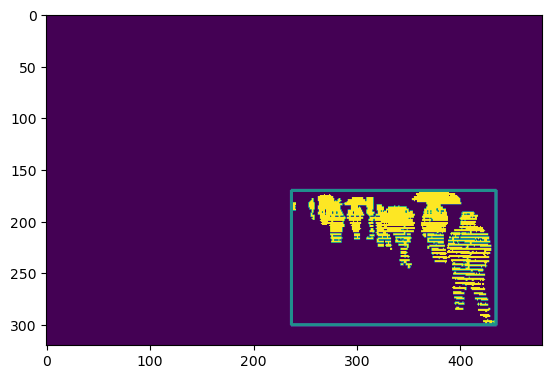

In [38]:
plt.imshow(anno_0_relable)

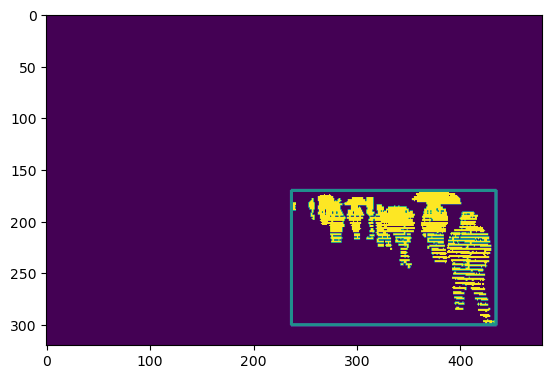

In [39]:
plt.imshow(image)

### Here are a visual example of how segmentation-json-create part works for image

In [160]:
# These info copied from the created seg-json file for waymo. Just a random copy.
example = {
      "area": 604,
      "bbox": [
        107,
        166,
        187,
        41
      ],
      "category_id": 2,
      "id": 1,
      "image_id": 1,
      "iscrowd": 0,
      "segmentation": {
        "counts": "ZdQ11f94]FNZ9NjF4LNY90iF3NMY90eFN250MY93gFO1LZ90cF2131MNO`94bFMNO`94bFLc9O\\F022`92`FMN0_93`FM0010e90ZF010e90ZF001`92`FM0001`92`FM0001`95`FJ01`92`FM001O`91_F0000001`9O`F0000001c9O]F00001c9O]F00001c9O]F00001`9O`F000001O`91_F00000d90\\F00000d90\\F00000d90\\F00000d90\\F00000d90\\F0000000a90_F0000000a90_F030M1`9O`F021NOa90_F030M0a93bFMa90\\F030d90kc00X\\O30000001LUF1^d00_E0]c00a\\O3OO1000i[h0NYdWO1O0O20N100000Sn01jQO3O00020NLYFOl900020^O0PG0C0Z90QGOE102e91[F0W9MSG3FOW9OSG7n8HUG0C0j90VF0m90R:0nE0N200UFNj90VF0j93000MVF0j90VF0j90VF0j90VF0j933Mkc00T\\O1NOVF0g93YFMg93YFMh9OXF100j90VF0j90VF0j933MVni1",
        "size": [
          320,
          480
        ]
      }
    }

In [161]:
from pycocotools import coco, mask
def rle_to_bitmap(rle):
  bitmap = mask.decode(rle)
  return bitmap
mask_bitmap = rle_to_bitmap(example["segmentation"])

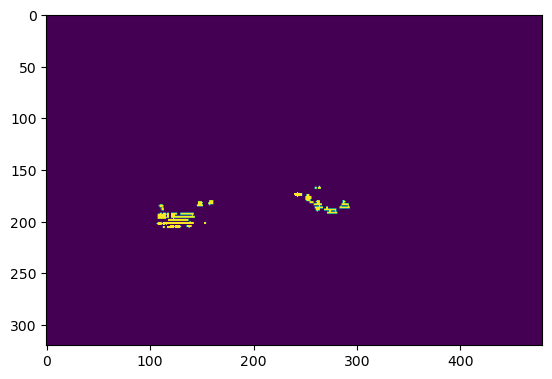

In [162]:
img = Image.fromarray(mask_bitmap.astype(np.uint8) * 255, mode='L')
plt.imshow(img)